In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import regularizers, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import random
import os

In [234]:
data = pd.read_csv('/content/insurance.csv')

## Data Preprocessing

In [235]:
data.isna().sum().sum()

0

In [236]:
print(data)

     age     sex     bmi  children smoker     region      charges
0     19  female  27.900         0    yes  southwest  16884.92400
1     18    male  33.770         1     no  southeast   1725.55230
2     28    male  33.000         3     no  southeast   4449.46200
3     33    male  22.705         0     no  northwest  21984.47061
4     32    male  28.880         0     no  northwest   3866.85520
..   ...     ...     ...       ...    ...        ...          ...
995   39  female  23.275         3     no  northeast   7986.47525
996   39  female  34.100         3     no  southwest   7418.52200
997   63  female  36.850         0     no  southeast  13887.96850
998   33  female  36.290         3     no  northeast   6551.75010
999   36  female  26.885         0     no  northwest   5267.81815

[1000 rows x 7 columns]


In [237]:
duplicate_data = data[data.duplicated(keep=False)]
print(duplicate_data)

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [238]:
cleaned_data = data.drop_duplicates()
print(cleaned_data)

     age     sex     bmi  children smoker     region      charges
0     19  female  27.900         0    yes  southwest  16884.92400
1     18    male  33.770         1     no  southeast   1725.55230
2     28    male  33.000         3     no  southeast   4449.46200
3     33    male  22.705         0     no  northwest  21984.47061
4     32    male  28.880         0     no  northwest   3866.85520
..   ...     ...     ...       ...    ...        ...          ...
995   39  female  23.275         3     no  northeast   7986.47525
996   39  female  34.100         3     no  southwest   7418.52200
997   63  female  36.850         0     no  southeast  13887.96850
998   33  female  36.290         3     no  northeast   6551.75010
999   36  female  26.885         0     no  northwest   5267.81815

[999 rows x 7 columns]


In [239]:
data = cleaned_data

In [240]:
# Statistical measures for charges

skewness = skew(data['charges'])
print(f'Skewness: {skewness}')

Skewness: 1.527688259892171


In [241]:
# Statistical measures for bmi

skewness = skew(data['bmi'])
print(f'Skewness: {skewness}')

Skewness: 0.23340290502291808


In [242]:
# Statistical measures for age

skewness = skew(data['age'])
print(f'Skewness: {skewness}')

Skewness: 0.02495828922758391


In [243]:
# IQR

Q1 = data[['age', 'charges']].quantile(0.25)
Q3 = data[['age', 'charges']].quantile(0.75)
IQR = Q3 - Q1
print("\nQ1:\n", Q1)
print("\nQ3:\n", Q3)
print("\nIQR:\n", IQR)

outliers = data[((data[['age', 'charges']] < (Q1 - 1.5 * IQR)) | (data[['age', 'charges']] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(outliers)



Q1:
 age          27.000000
charges    4729.002375
Name: 0.25, dtype: float64

Q3:
 age           52.000000
charges    15944.891875
Name: 0.75, dtype: float64

IQR:
 age           25.0000
charges    11215.8895
dtype: float64
     age     sex    bmi  children smoker     region     charges
14    27    male  42.13         0    yes  southeast  39611.7577
19    30    male  35.30         0    yes  southwest  36837.4670
23    34  female  31.92         1    yes  northeast  37701.8768
29    31    male  36.30         2    yes  southwest  38711.0000
30    22    male  35.60         0    yes  southwest  35585.5760
..   ...     ...    ...       ...    ...        ...         ...
947   37    male  34.20         1    yes  northeast  39047.2850
951   51    male  42.90         2    yes  southeast  47462.8940
953   44    male  30.20         2    yes  southwest  38998.5460
956   54    male  30.80         1    yes  southeast  41999.5200
958   43    male  34.96         1    yes  northeast  41034.2214

[107 

Calculation of charges outliner

*   Lower bound: Q1 - 1.5 * IQR = 4729.002375 - 1.5 * 11215.8895 = -12264.834875

*   Upper bound: Q3 + 1.5 * IQR = 15944.891875 + 1.5 * 11215.8895 = 32794.724625



In [244]:
#Clamping

def clamp_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

    return data

# Clamp outliers 'charges'
clamped_data = clamp_outliers_iqr(data.copy(), 'charges')
print(clamped_data)

     age     sex     bmi  children smoker     region      charges
0     19  female  27.900         0    yes  southwest  16884.92400
1     18    male  33.770         1     no  southeast   1725.55230
2     28    male  33.000         3     no  southeast   4449.46200
3     33    male  22.705         0     no  northwest  21984.47061
4     32    male  28.880         0     no  northwest   3866.85520
..   ...     ...     ...       ...    ...        ...          ...
995   39  female  23.275         3     no  northeast   7986.47525
996   39  female  34.100         3     no  southwest   7418.52200
997   63  female  36.850         0     no  southeast  13887.96850
998   33  female  36.290         3     no  northeast   6551.75010
999   36  female  26.885         0     no  northwest   5267.81815

[999 rows x 7 columns]


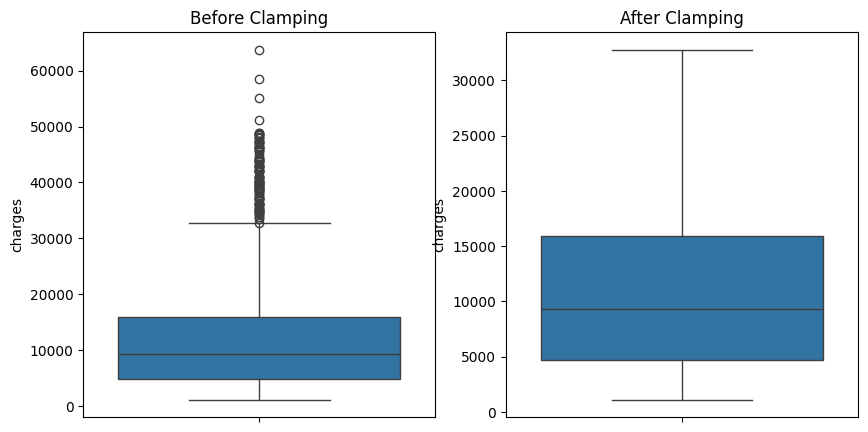

In [245]:
# Before clamping
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=data['charges'])
plt.title("Before Clamping")

# After clamping
plt.subplot(1, 2, 2)
sns.boxplot(y=clamped_data['charges'])
plt.title("After Clamping")

plt.show()

In [246]:
skewness = skew(clamped_data['charges'])
print(f'Skewness: {skewness}')

Skewness: 1.0290406855287897


In [247]:
clamped_data['charges'] = np.log(clamped_data['charges'])

skewness = skew(clamped_data['charges'])
print(f'Skewness: {skewness}')

Skewness: -0.2559955627423052


In [248]:
data['charges'] = np.log(data['charges'])

skewness = skew(data['charges'])
print(f'Skewness: {skewness}')

Skewness: -0.09254709857438813


Data with log transformation has lesser skew value than log transformation + clamping

So we will be considering the non clamped data



In [249]:
data['sex'] = data['sex'].astype('category').cat.codes
data['smoker'] = data['smoker'].astype('category').cat.codes
data['region'] = data['region'].astype('category').cat.codes

In [250]:
print(data)

     age  sex     bmi  children  smoker  region   charges
0     19    0  27.900         0       1       3  9.734176
1     18    1  33.770         1       0       2  7.453302
2     28    1  33.000         3       0       2  8.400538
3     33    1  22.705         0       0       1  9.998092
4     32    1  28.880         0       0       1  8.260197
..   ...  ...     ...       ...     ...     ...       ...
995   39    0  23.275         3       0       0  8.985505
996   39    0  34.100         3       0       3  8.911735
997   63    0  36.850         0       0       2  9.538778
998   33    0  36.290         3       0       0  8.787487
999   36    0  26.885         0       0       1  8.569372

[999 rows x 7 columns]


In [251]:
y = data['charges']
X = data.drop('charges', axis=1)

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [253]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Neural Network

In [254]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(6,)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [255]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [266]:
early_stopping = EarlyStopping(monitor='val_mse', patience=40, mode='max', verbose=1)

In [267]:
model.fit(X_train, y_train, epochs=75, batch_size=8, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/75
90/90 [==============================] - 0s 3ms/step - loss: 0.2158 - mse: 0.1824 - val_loss: 0.1566 - val_mse: 0.1237
Epoch 2/75
90/90 [==============================] - 0s 2ms/step - loss: 0.2186 - mse: 0.1866 - val_loss: 0.1634 - val_mse: 0.1320
Epoch 3/75
90/90 [==============================] - 0s 3ms/step - loss: 0.2041 - mse: 0.1734 - val_loss: 0.1840 - val_mse: 0.1539
Epoch 4/75
90/90 [==============================] - 0s 3ms/step - loss: 0.2100 - mse: 0.1807 - val_loss: 0.1748 - val_mse: 0.1463
Epoch 5/75
90/90 [==============================] - 0s 3ms/step - loss: 0.1889 - mse: 0.1610 - val_loss: 0.1922 - val_mse: 0.1649
Epoch 6/75
90/90 [==============================] - 0s 3ms/step - loss: 0.2023 - mse: 0.1756 - val_loss: 0.1382 - val_mse: 0.1122
Epoch 7/75
90/90 [==============================] - 0s 2ms/step - loss: 0.2001 - mse: 0.1748 - val_loss: 0.1764 - val_mse: 0.1519
Epoch 8/75
90/90 [==============================] - 0s 3ms/step - loss: 0.1966 - mse: 0.17

In [268]:
test_loss, test_mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", test_mse)

7/7 [==============================] - 0s 4ms/step - loss: 0.1499 - mse: 0.1420
Mean Squared Error: 0.14202193915843964


Linear Regression

In [259]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

predictions = linear_reg.predict(X_test)

mse_linear_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_linear_reg)

Mean Squared Error: 0.1853652466483362


Decision Tree Regression

In [260]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

# Predict
predictions = tree_reg.predict(X_test)

# Evaluate
mse_tree_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_tree_reg)

Mean Squared Error: 0.16115641205252693


Random Forest Regression

In [261]:
forest_reg = RandomForestRegressor(n_estimators=100)
forest_reg.fit(X_train, y_train)

predictions = forest_reg.predict(X_test)

mse_forest_reg = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse_forest_reg)

Mean Squared Error: 0.15169826218332197


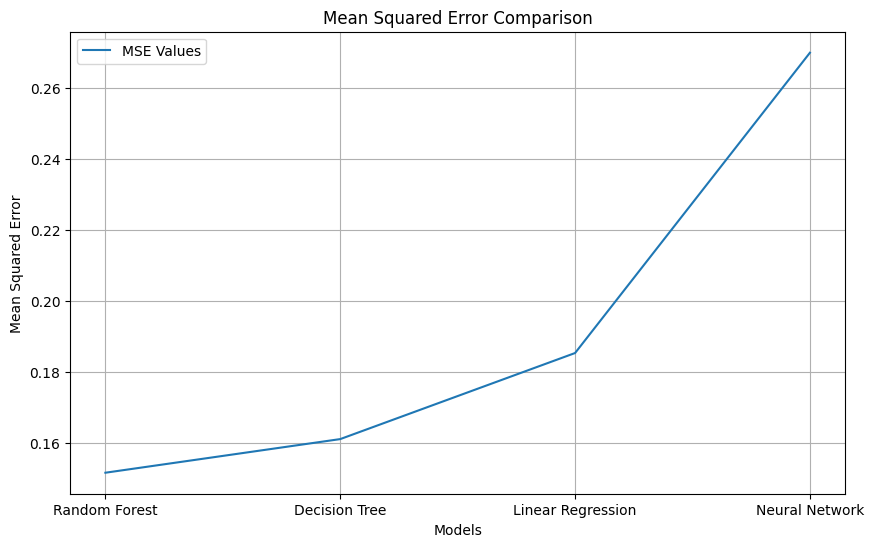

In [262]:
mse_values = [mse_forest_reg, mse_tree_reg, mse_linear_reg, test_mse]
model_names = ['Random Forest', 'Decision Tree', 'Linear Regression', 'Neural Network']

plt.figure(figsize=(10, 6))
plt.plot(model_names, mse_values, label='MSE Values')
plt.title('Mean Squared Error Comparison')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()
plt.show()

Among the 4 models

*   Neural Network performs the best

*   Random Forest - 2nd

*   Decision Tree - 3rd

*   Linear Regression - 4th  

Why Neural Network performed the best

* They are very adaptable to various types of data.
* Regularization and dropout feature prevents data from overfitting.
* They are very good in handling non-linear and complex data



We can see that, age vs charges and bmi vs charges scatter plot that shows non-linearity, which shows why neural network performs the best



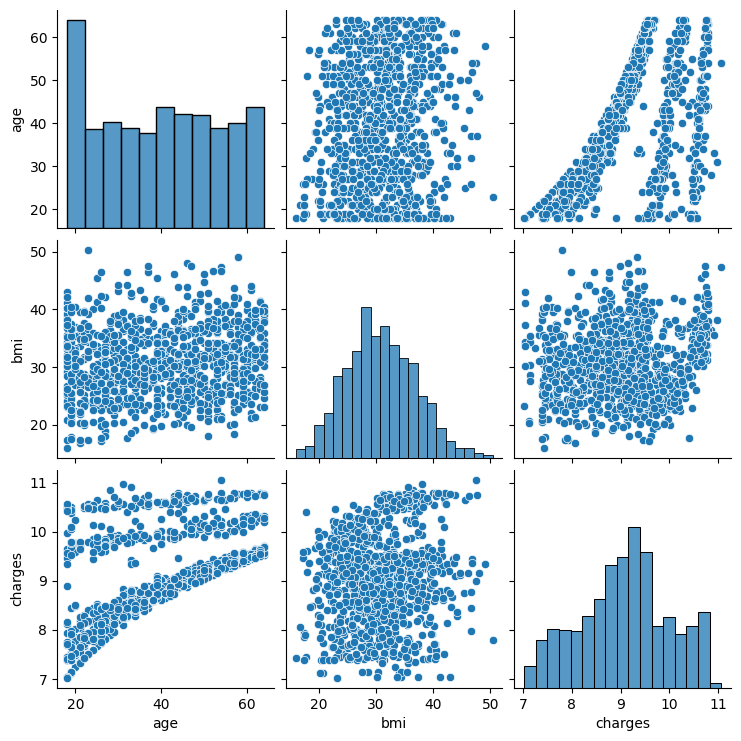

In [263]:
subset_data = data[['age', 'bmi', 'charges']]

sns.pairplot(subset_data)
plt.show()

2nd Random Forest and 3rd Decision Tree

* Random forest work by combining multiple decision trees, which can produce better generalization and robustness compared to decision tree.

* Random forest are insensivite to outliners.

* Probablity of overfitting is less for random forest.


* Probablity of overfitting is less for random forest
Decision trees can easily overfit to the training data, leading to poor performance on the test set.

* High Sensitivity

* Probablity of overfitting is less for random forest.

4th - Linear Regression
* In the scatter plot we can see that, there are many data points that do not lie near the red line
* We can see the data is clustered with gaps in between, which means there exist a more complex relationship that linear reg cannot understand
* For higher values the prediction goes wrong



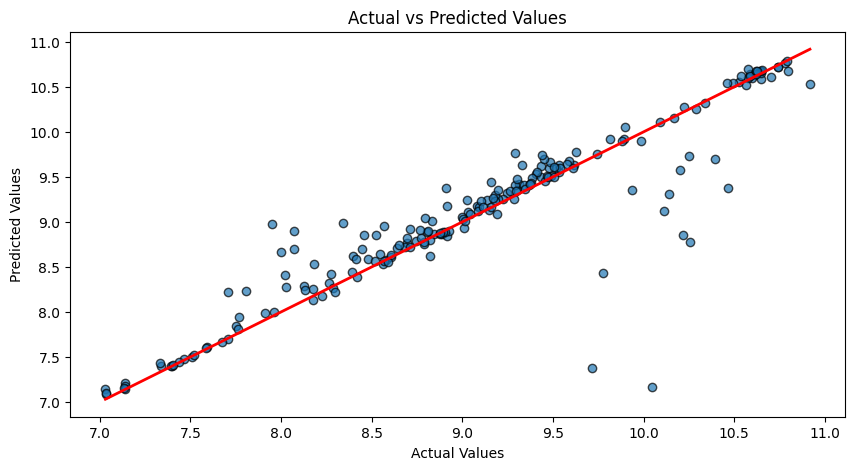

In [264]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Fitted values or predicted values are plotted along with residual

We can see a slight curve, which says the relationship between the dependent and independent variable is not linear

There are potential outliners

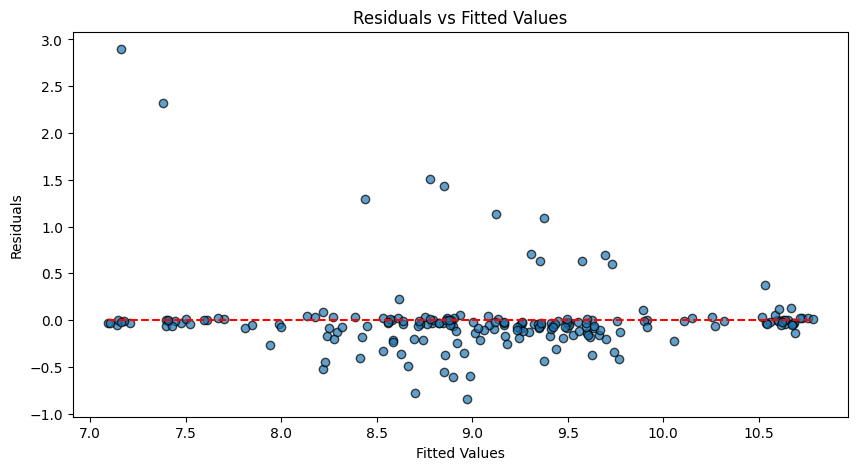

In [265]:
plt.figure(figsize=(10, 5))
plt.scatter(predictions, residuals, edgecolor='k', alpha=0.7)
plt.hlines(y=0, xmin=min(predictions), xmax=max(predictions), colors='red', linestyles='dashed')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()